### Modelo de ML. Primera versión.

Antes que nada, cabe destacar que el conjunto de datos contiene determinados atributos que, de introducirse en el modelo, provocarían un 'data leakage'. Dicho de otra manera, se estarían introduciendo datos que realmente no estarían disponibles en el momento de hacer la predicción. 

Nos referimos principalmente a la variable 'score', que incluye el resultado del partido, pero también a los atributos que hacen referencia al rendimiento de los jugadores durante el partido (como 'w_ace, w_df, etc.). Teniendo en cuenta que estos últimos representan una parte muy importante de la base de datos y que realmente no determinan qué jugador ha ganado el partido, sino que solamente dan información sobre su nivel de juego, se ha optado por hacer dos versiones del conjunto de datos para entrenar los modelos con el objetivo de comparar los resultados. En la práctica, lo ideal sería incluir datos sobre el rendimiento medio de los jugadores en partidos pasados, de esta manera el modelo tendría más información sobre el nivel de juego de los jugadores y no se produciría ningún data leakage.

Así pues, en esta primera versión se incluirán los atributos relativos al rendimiento de los jugadores durante el partido, y en la segunda no. 

In [27]:
import pandas as pd
import numpy as np
from random import seed
from random import randint

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import classification_report, mean_squared_error as mse
from joblib import dump

import warnings
warnings.filterwarnings("ignore")

In [28]:
df = pd.read_csv('/Users/juliacorominasfont/Desktop/DS BOOTCAMP/Projecte Final/ML/clean_data.csv')
df.head(5)

,Unnamed: 0,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,...,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,loser_rank,year
0,0,1991-339,Adelaide,Hard,32,A,1990-12-31,1,101723,Magnus Larsson,...,95.0,62.0,44.0,23.0,16.0,6.0,8.0,56.0,2.0,1990
1,1,1991-339,Adelaide,Hard,32,A,1990-12-31,2,100946,Slobodan Zivojinovic,...,84.0,41.0,35.0,27.0,15.0,1.0,2.0,304.0,75.0,1990
2,2,1991-339,Adelaide,Hard,32,A,1990-12-31,3,101234,Patrik Kuhnen,...,60.0,37.0,22.0,6.0,8.0,4.0,8.0,82.0,69.0,1990
3,3,1991-339,Adelaide,Hard,32,A,1990-12-31,4,101889,Todd Woodbridge,...,74.0,45.0,30.0,11.0,10.0,5.0,8.0,50.0,84.0,1990
4,4,1991-339,Adelaide,Hard,32,A,1990-12-31,5,101274,Udo Riglewski,...,77.0,41.0,28.0,15.0,11.0,4.0,8.0,88.0,28.0,1990


Primero, eliminamos la variable 'score', ya que nos da directamente el resultado del partido.

In [29]:
df.drop(['Unnamed: 0', 'score'], axis=1, inplace=True)

In [30]:
df.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_name', 'winner_hand',
       'winner_ht', 'winner_ioc', 'winner_age', 'loser_id', 'loser_name',
       'loser_hand', 'loser_ht', 'loser_ioc', 'loser_age', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'loser_rank', 'year'],
      dtype='object')

Asimismo, vemos que la tabla identifica a los jugadores como Winner y Loser, por lo que para el modelo sería muy obvio quien gana el partido. Es por esto que aleatoriamente asignaremos el número 1 o 2 a todos los jugadores, creando un label que sea 1, cuando el jugador 1 gane el partido, y 0 cuando gane el jugador 2.

In [31]:
from random import seed
from random import randint

def assign_players(row):
    random_number = randint(1, 2)
    if random_number == 1:
        return (
            row['winner_id'], row['winner_name'], row['winner_hand'], row['winner_ht'], row['winner_ioc'], row['winner_age'],
            row['w_ace'], row['w_df'], row['w_svpt'], row['w_1stIn'], row['w_1stWon'], row['w_2ndWon'], row['w_SvGms'],
            row['w_bpSaved'], row['w_bpFaced'], row['winner_rank'],
            row['loser_id'], row['loser_name'], row['loser_hand'], row['loser_ht'], row['loser_ioc'], row['loser_age'],
            row['l_ace'], row['l_df'], row['l_svpt'], row['l_1stIn'], row['l_1stWon'], row['l_2ndWon'], row['l_SvGms'],
            row['l_bpSaved'], row['l_bpFaced'], row['loser_rank']
        )
    else:
        return (
            row['loser_id'], row['loser_name'], row['loser_hand'], row['loser_ht'], row['loser_ioc'], row['loser_age'],
            row['l_ace'], row['l_df'], row['l_svpt'], row['l_1stIn'], row['l_1stWon'], row['l_2ndWon'], row['l_SvGms'],
            row['l_bpSaved'], row['l_bpFaced'], row['loser_rank'],
            row['winner_id'], row['winner_name'], row['winner_hand'], row['winner_ht'], row['winner_ioc'], row['winner_age'],
            row['w_ace'], row['w_df'], row['w_svpt'], row['w_1stIn'], row['w_1stWon'], row['w_2ndWon'], row['w_SvGms'],
            row['w_bpSaved'], row['w_bpFaced'], row['winner_rank']
        )

def create_player_columns(df):
    df[['Player1_id', 'Player1_name', 'Player1_hand', 'Player1_ht', 'Player1_ioc', 'Player1_age',
        'Player1_ace', 'Player1_df', 'Player1_svpt', 'Player1_1stIn', 'Player1_1stWon', 'Player1_2ndWon', 'Player1_SvGms',
        'Player1_bpSaved', 'Player1_bpFaced', 'Player1_rank',
        'Player2_id', 'Player2_name', 'Player2_hand', 'Player2_ht', 'Player2_ioc', 'Player2_age',
        'Player2_ace', 'Player2_df', 'Player2_svpt', 'Player2_1stIn', 'Player2_1stWon', 'Player2_2ndWon', 'Player2_SvGms',
        'Player2_bpSaved', 'Player2_bpFaced', 'Player2_rank']] = df.apply(assign_players, axis=1, result_type='expand')
    return df

def create_label(df):
    return 1 if df['winner_id'] == df['Player1_id'] else 0

def df_preprocessing(df):
    df = create_player_columns(df)
    df['label'] = df.apply(create_label, axis=1)
    df.drop(columns=['winner_id', 'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age', 'w_ace', 'w_df',
                     'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'loser_id',
                     'loser_name', 'loser_hand', 'loser_ht', 'loser_ioc', 'loser_age', 'l_ace', 'l_df', 'l_svpt',
                     'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced', 'winner_rank', 'loser_rank'],
            inplace=True)
    return df

df = df_preprocessing(df)
df.head(5)

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,best_of,round,minutes,...,Player2_df,Player2_svpt,Player2_1stIn,Player2_1stWon,Player2_2ndWon,Player2_SvGms,Player2_bpSaved,Player2_bpFaced,Player2_rank,label
0,1991-339,Adelaide,Hard,32,A,1990-12-31,1,3,R32,130.0,...,3.0,95.0,62.0,44.0,23.0,16.0,6.0,8.0,2.0,1
1,1991-339,Adelaide,Hard,32,A,1990-12-31,2,3,R32,119.0,...,4.0,101.0,56.0,45.0,25.0,15.0,9.0,10.0,304.0,0
2,1991-339,Adelaide,Hard,32,A,1990-12-31,3,3,R32,71.0,...,2.0,60.0,37.0,22.0,6.0,8.0,4.0,8.0,69.0,1
3,1991-339,Adelaide,Hard,32,A,1990-12-31,4,3,R32,85.0,...,3.0,74.0,45.0,30.0,11.0,10.0,5.0,8.0,84.0,1
4,1991-339,Adelaide,Hard,32,A,1990-12-31,5,3,R32,90.0,...,2.0,72.0,40.0,33.0,14.0,10.0,7.0,8.0,88.0,0


Estudiamos la correlación entre las variables y con el label.

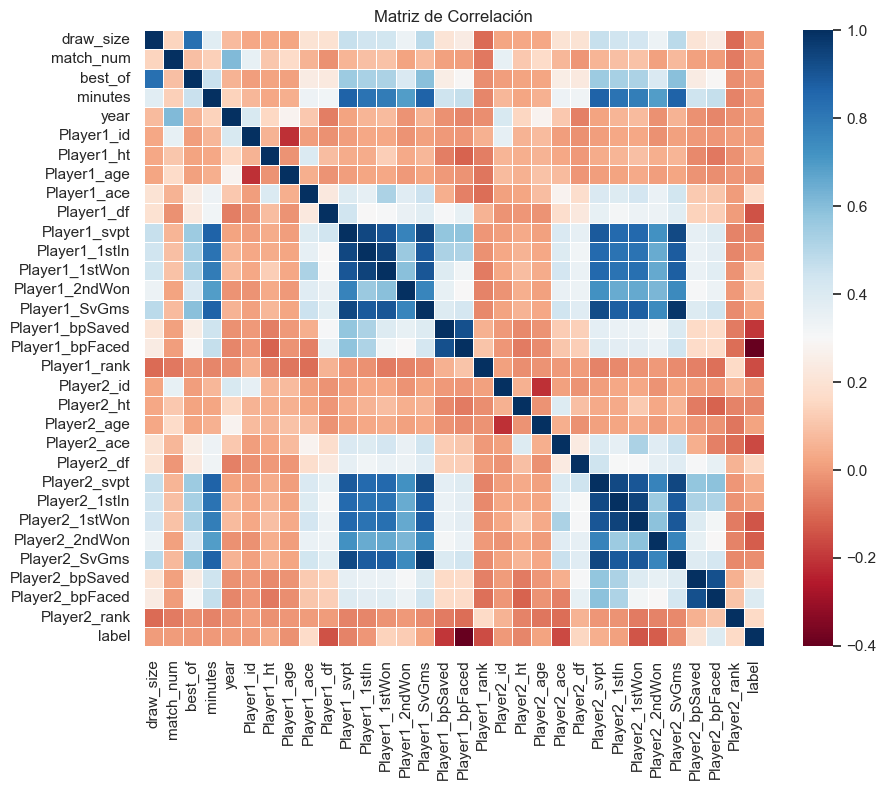

In [32]:
plt.figure(figsize=(10, 8))  # Ajusta el tamaño del gráfico según tus preferencias
sns.heatmap(df.corr(), cmap="RdBu", fmt=".2f", linewidths=.5)
plt.title("Matriz de Correlación")
plt.show()

In [33]:
df.corr()['label'].sort_values()

Player1_bpFaced   -0.400978
Player1_bpSaved   -0.199339
Player2_ace       -0.163512
Player1_rank      -0.160163
Player1_df        -0.148898
Player2_1stWon    -0.139424
Player2_2ndWon    -0.121903
Player1_svpt      -0.048588
Player2_ht        -0.041279
Player2_SvGms     -0.024652
Player1_age       -0.019528
Player1_1stIn     -0.011972
minutes           -0.002503
best_of           -0.002470
Player2_id        -0.002150
draw_size         -0.000478
year              -0.000145
match_num          0.001110
Player1_id         0.002275
Player2_1stIn      0.010545
Player2_age        0.018795
Player1_SvGms      0.023641
Player1_ht         0.041306
Player2_svpt       0.047513
Player1_2ndWon     0.121914
Player1_1stWon     0.138564
Player2_df         0.147139
Player2_rank       0.158572
Player1_ace        0.167329
Player2_bpSaved    0.196277
Player2_bpFaced    0.397374
label              1.000000
Name: label, dtype: float64

Vemos que los atributos con mayor correlación con el 'label' son aquellos relacionados con los puntos de rotura (break points), los aces, el ranking de los jugadores y los servicios. Tiene sentido por cuanto: 
- los puntos de rotura son puntos decisivos en el partido,
- es coherente que a mejor posición en el ranking, más probable sea que el jugador gane, y
- la eficiencia del servicio tiene un fuerte impacto en el partido, ya que puede llevar a un punto de rotura o a un juego de servicio.

In [34]:
df.shape

(94344, 44)

In [35]:
df.duplicated().sum()

0

In [36]:
df['label'].unique()

array([1, 0])

In [37]:
dump(df, 'datos.df')

['datos.df']

### EDA de los datos para entrenar el modelo

<Figure size 800x500 with 0 Axes>

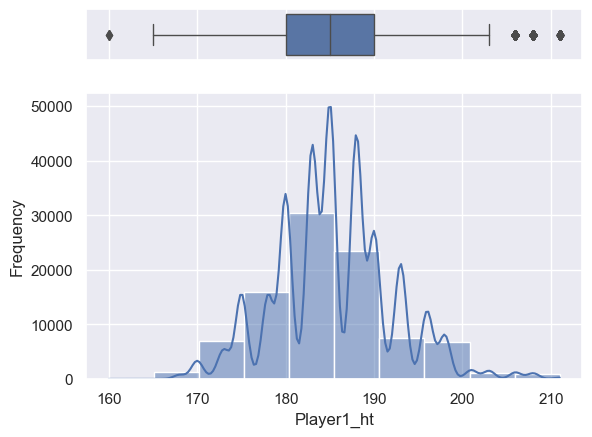

<Figure size 800x500 with 0 Axes>

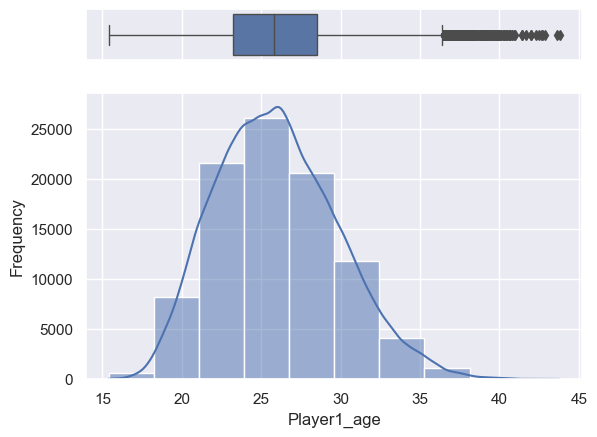

<Figure size 800x500 with 0 Axes>

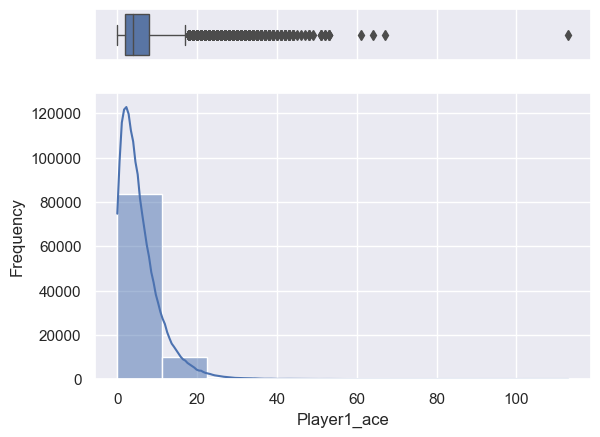

<Figure size 800x500 with 0 Axes>

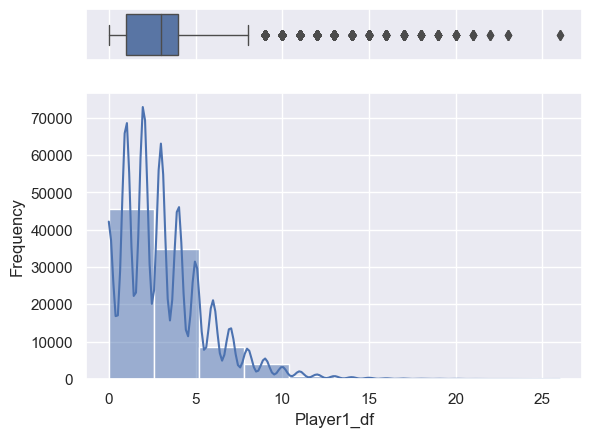

<Figure size 800x500 with 0 Axes>

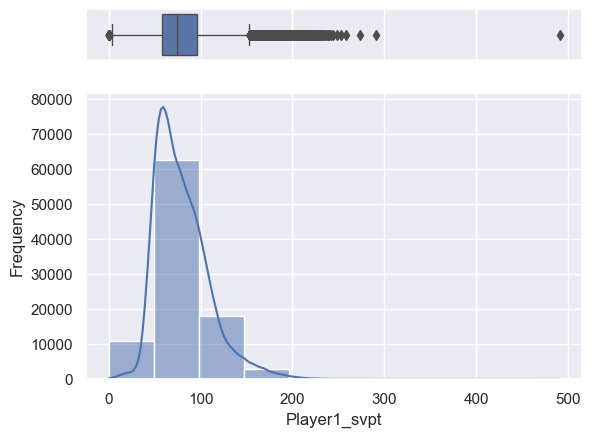

<Figure size 800x500 with 0 Axes>

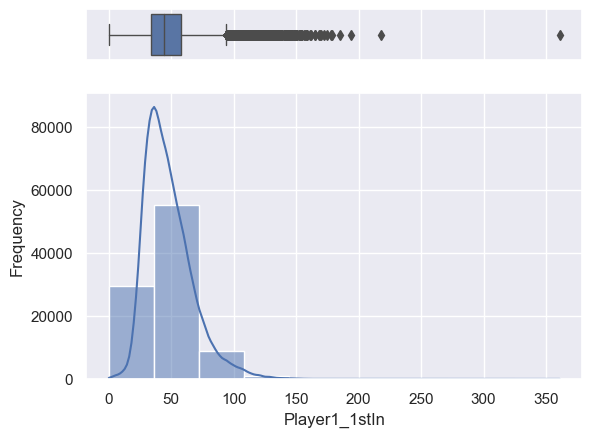

<Figure size 800x500 with 0 Axes>

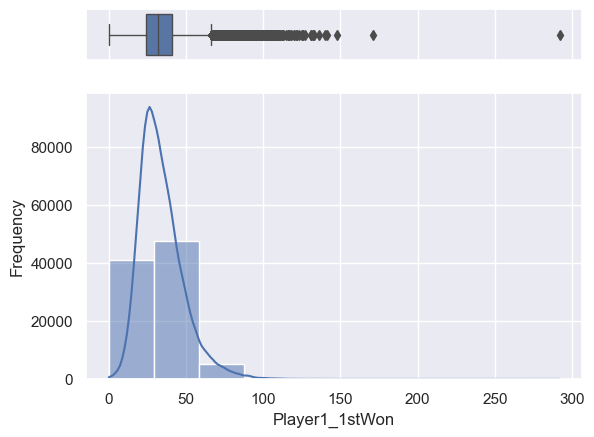

<Figure size 800x500 with 0 Axes>

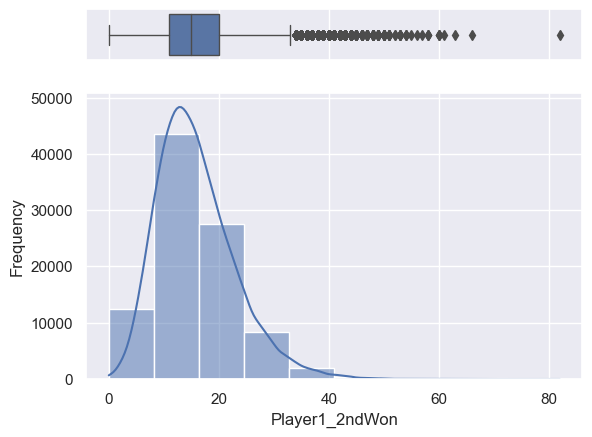

<Figure size 800x500 with 0 Axes>

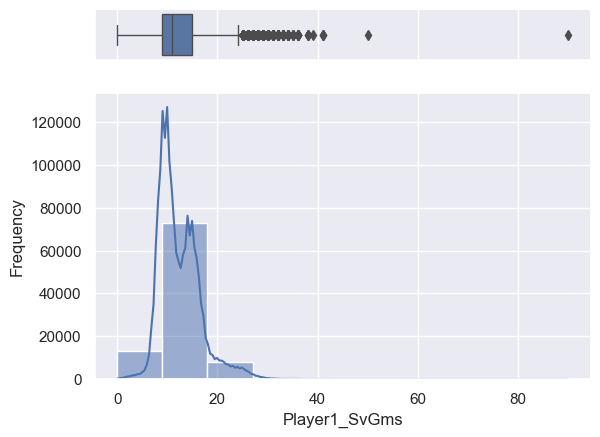

<Figure size 800x500 with 0 Axes>

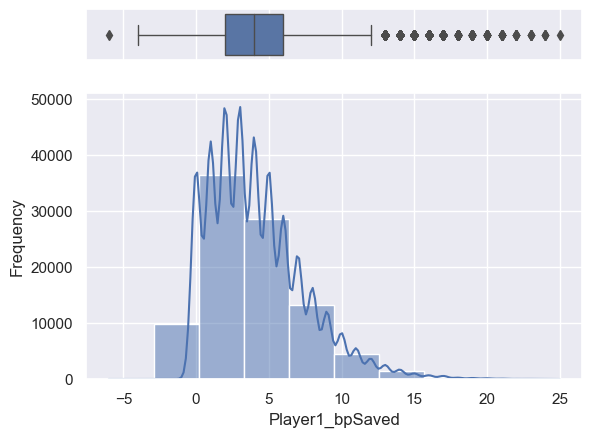

<Figure size 800x500 with 0 Axes>

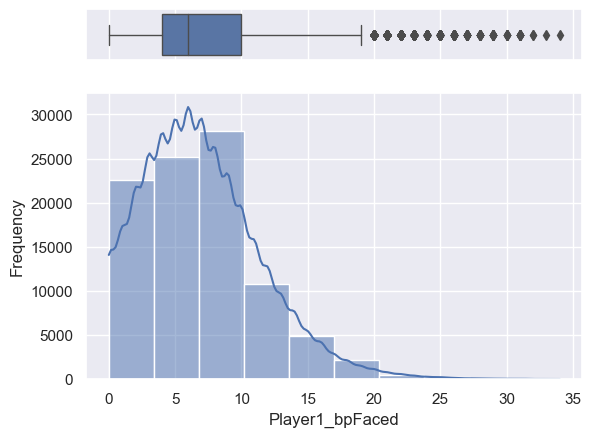

<Figure size 800x500 with 0 Axes>

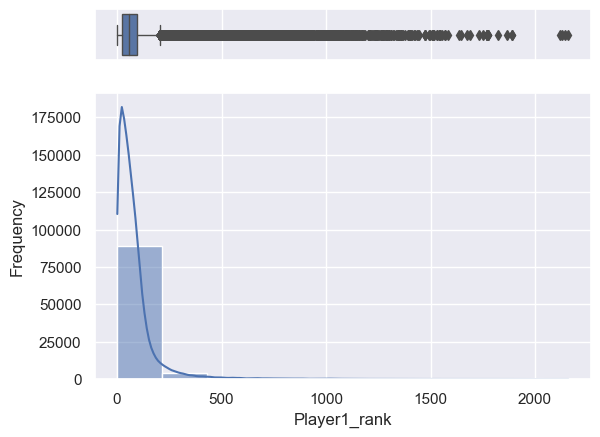

<Figure size 800x500 with 0 Axes>

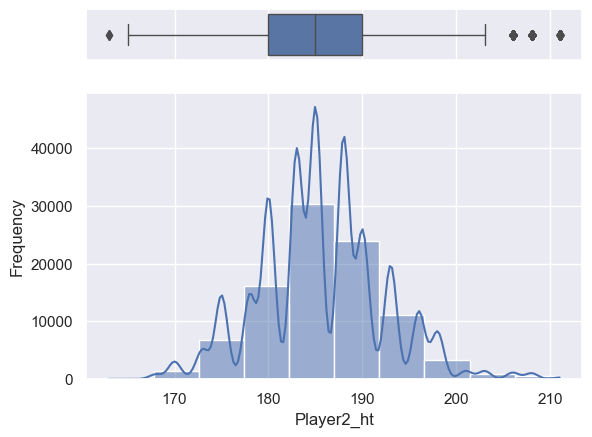

<Figure size 800x500 with 0 Axes>

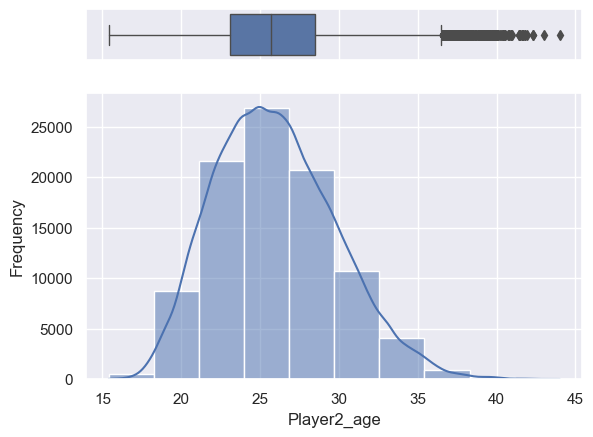

<Figure size 800x500 with 0 Axes>

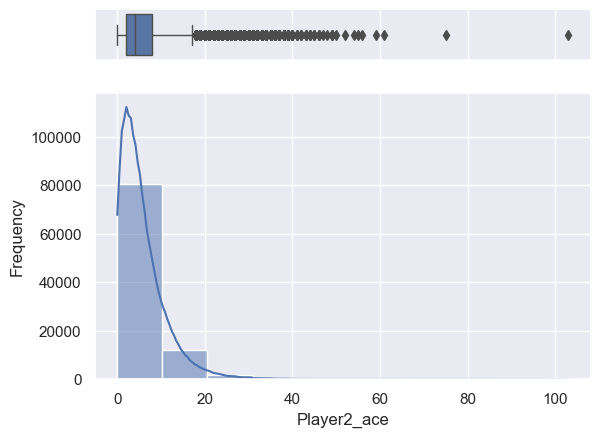

<Figure size 800x500 with 0 Axes>

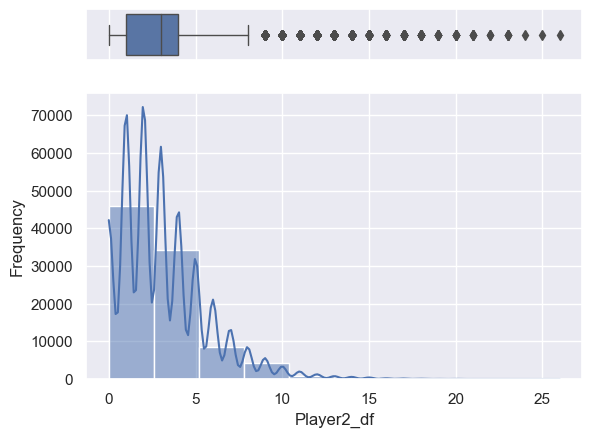

<Figure size 800x500 with 0 Axes>

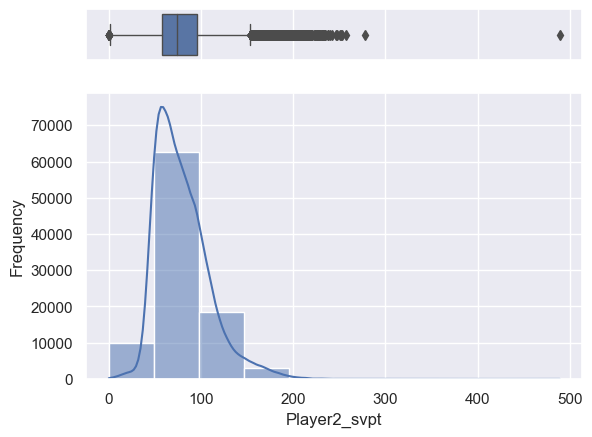

<Figure size 800x500 with 0 Axes>

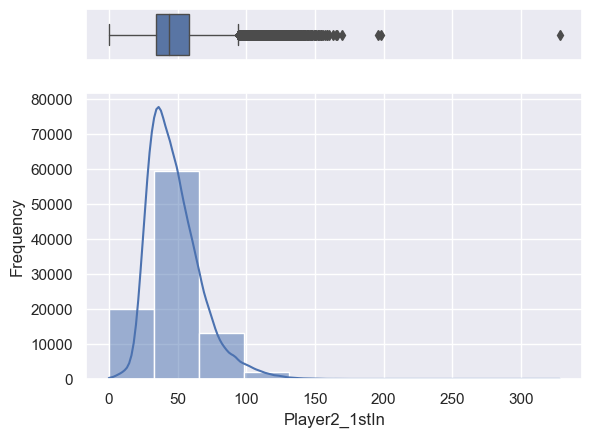

<Figure size 800x500 with 0 Axes>

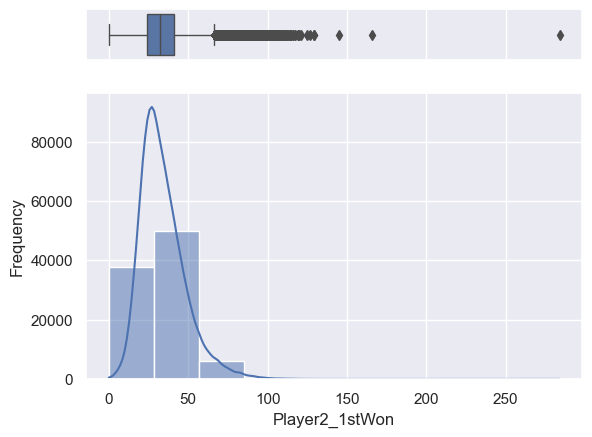

<Figure size 800x500 with 0 Axes>

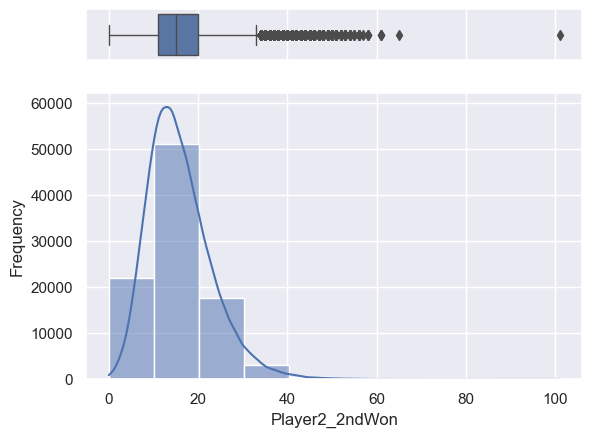

<Figure size 800x500 with 0 Axes>

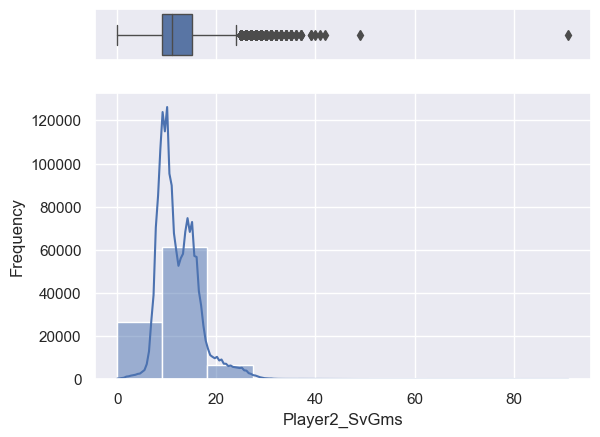

<Figure size 800x500 with 0 Axes>

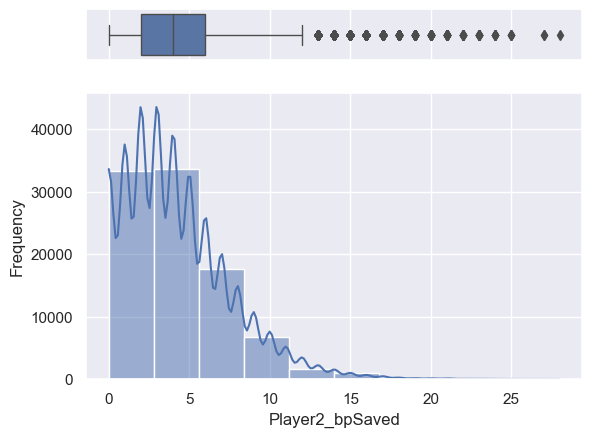

<Figure size 800x500 with 0 Axes>

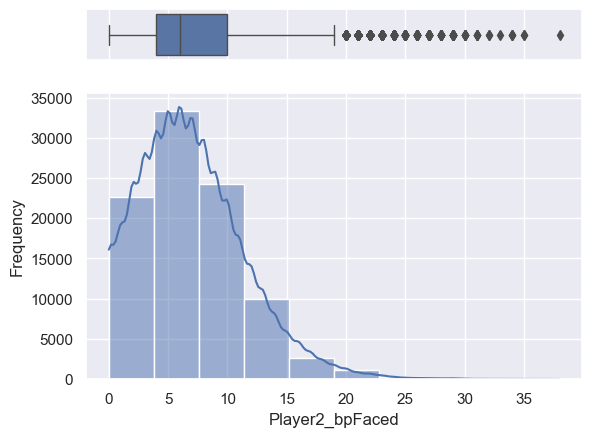

<Figure size 800x500 with 0 Axes>

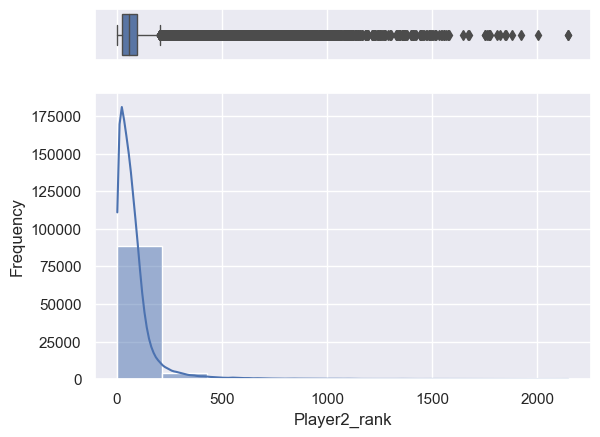

In [38]:
numerical_features = ['Player1_ht', 'Player1_age', 'Player1_ace', 'Player1_df','Player1_svpt', 'Player1_1stIn', 'Player1_1stWon', 'Player1_2ndWon', 'Player1_SvGms', 'Player1_bpSaved', 'Player1_bpFaced', 'Player1_rank', 'Player2_ht', 'Player2_age', 'Player2_ace','Player2_df', 'Player2_svpt', 'Player2_1stIn', 'Player2_1stWon', 'Player2_2ndWon', 'Player2_SvGms', 'Player2_bpSaved','Player2_bpFaced', 'Player2_rank']

for i in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.set()
    
    filtered_data = df[df[i].notna()]
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    
    sns.boxplot(x=df[i], orient="h", ax=ax_box, linewidth=1.0)
    
    # Dibuja el histograma en la parte inferior
    sns.histplot(df[i], ax=ax_hist, bins=10, kde=True)
    
    ax_box.set(xlabel='')
    ax_hist.set(xlabel=i)
    
    plt.gca().set(xlabel= i,ylabel='Frequency')

Vemos que las variables 'Player1_ht' y 'Player2_ht' tienen una distribución normal, y el resto no son normales y tienen outliers. Por tanto, aplicaremos StandardScaler() a las primeras y el RobustScaler() a las segundas.

### Transformaciones

#### Variables numéricas

Hemos visto que ninguna tiene una distribución normal y que todas tienen outliers.

In [39]:
numeric_features = ['Player1_ht', 'Player2_ht']
numeric_transformer = Pipeline(
    steps=[
        ('imputer_num', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

numeric_features_out = ['Player1_age', 'Player1_ace', 'Player1_df','Player1_svpt', 'Player1_1stIn', 'Player1_1stWon', 'Player1_2ndWon', 'Player1_SvGms', 'Player1_bpSaved', 'Player1_bpFaced', 'Player1_rank', 'Player2_age', 'Player2_ace','Player2_df', 'Player2_svpt', 'Player2_1stIn', 'Player2_1stWon', 'Player2_2ndWon', 'Player2_SvGms', 'Player2_bpSaved','Player2_bpFaced', 'Player2_rank']
numeric_transformer_out = Pipeline(
    [
        ('imputer_num', SimpleImputer(strategy = 'median')),
        ('robust', RobustScaler())
    ]
)

#### Variables categóricas

Aplicaremos la técnica OneHotEncoding a todas las variables ya que tienen más de dos valores.

In [40]:
categorical_features = ['surface', 'tourney_level', 'round', 'Player1_hand', 'Player2_hand']
categorical_transformer = Pipeline(
    [
        ('imputer_cat', SimpleImputer(strategy = 'most_frequent')),
        ('onehot', OneHotEncoder(sparse=False))
    ]
)

#### Pipeline

Aplicamos las transformaciones anteriores al conjunto de datos con el ColumnTransformer(). Este Pipeline es el que aplicaremos cuando hagamos los modelos.

In [41]:
preprocessor = ColumnTransformer(
    [
        ('categoricals', categorical_transformer, categorical_features),
        ('numericals', numeric_transformer, numeric_features),
        ('numericals_out', numeric_transformer_out, numeric_features_out) 
    ],
    remainder = 'drop'
)

In [42]:
preprocessor

ColumnTransformer(transformers=[('categoricals',
                                 Pipeline(steps=[('imputer_cat',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(sparse=False))]),
                                 ['surface', 'tourney_level', 'round',
                                  'Player1_hand', 'Player2_hand']),
                                ('numericals',
                                 Pipeline(steps=[('imputer_num',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Player1_ht'...
                                 ['Player1_age', 'Player1_ace', 'Player1_df',
                                  'Player1_svpt', 'Player1_1stIn',
                                  'Player1_1stWon', 'Player1_2ndWon',
                                  'Player1_SvGms', 'Player1_bpSaved',
                                  'Player1_bpFaced', 'Player1_rank',
                                  'Player2_age', 'Player2_ace', 'Player2_df',
                                  'Player2_svpt', 'Player2_1stIn',
                                  'Player2_1stWon', 'Player2_2ndWon',
                                  'Player2_SvGms', 'Player2_bpSaved',
                                  'Player2_bpFaced', 'Player2_rank'])])

### Train y Test

In [43]:
df

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,best_of,round,minutes,...,Player2_df,Player2_svpt,Player2_1stIn,Player2_1stWon,Player2_2ndWon,Player2_SvGms,Player2_bpSaved,Player2_bpFaced,Player2_rank,label
0,1991-339,Adelaide,Hard,32,A,1990-12-31,1,3,R32,130.0,...,3.0,95.0,62.0,44.0,23.0,16.0,6.0,8.0,2.0,1
1,1991-339,Adelaide,Hard,32,A,1990-12-31,2,3,R32,119.0,...,4.0,101.0,56.0,45.0,25.0,15.0,9.0,10.0,304.0,0
2,1991-339,Adelaide,Hard,32,A,1990-12-31,3,3,R32,71.0,...,2.0,60.0,37.0,22.0,6.0,8.0,4.0,8.0,69.0,1
3,1991-339,Adelaide,Hard,32,A,1990-12-31,4,3,R32,85.0,...,3.0,74.0,45.0,30.0,11.0,10.0,5.0,8.0,84.0,1
4,1991-339,Adelaide,Hard,32,A,1990-12-31,5,3,R32,90.0,...,2.0,72.0,40.0,33.0,14.0,10.0,7.0,8.0,88.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94339,2023-0605,Tour Finals,Hard,8,A,2023-11-13,290,3,RR,74.0,...,2.0,61.0,45.0,28.0,8.0,10.0,3.0,6.0,5.0,1
94340,2023-0605,Tour Finals,Hard,8,A,2023-11-13,289,3,RR,151.0,...,2.0,97.0,75.0,59.0,11.0,16.0,5.0,6.0,7.0,0
94341,2023-0605,Tour Finals,Hard,8,A,2023-11-13,288,3,RR,91.0,...,3.0,64.0,36.0,30.0,14.0,9.0,7.0,7.0,3.0,0
94342,2023-0605,Tour Finals,Hard,8,A,2023-11-13,287,3,RR,105.0,...,0.0,67.0,51.0,34.0,10.0,11.0,0.0,2.0,7.0,1


In [44]:
X = df.drop('label', axis=1)
y = df['label']

In [45]:
y.value_counts()

0    47418
1    46926
Name: label, dtype: int64

Vemos que el 'label' está balanceado, no hace falta aplicar técnicas de balanceo.

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
X_train

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,best_of,round,minutes,...,Player2_ace,Player2_df,Player2_svpt,Player2_1stIn,Player2_1stWon,Player2_2ndWon,Player2_SvGms,Player2_bpSaved,Player2_bpFaced,Player2_rank
8875,1993-423,Los Angeles,Hard,32,A,1993-08-02,11,3,R32,133.0,...,2.0,6.0,91.0,33.0,23.0,28.0,13.0,4.0,9.0,567.0
20017,1997-339,Adelaide,Hard,32,A,1996-12-30,2,3,R32,63.0,...,10.0,3.0,46.0,25.0,21.0,9.0,9.0,1.0,3.0,73.0
34590,2001-560,US Open,Hard,128,G,2001-08-27,10,5,R128,161.0,...,27.0,12.0,134.0,61.0,46.0,38.0,19.0,6.0,11.0,96.0
75413,2016-0315,Newport,Grass,32,A,2016-07-11,293,3,R16,59.0,...,2.0,0.0,41.0,21.0,11.0,13.0,8.0,1.0,4.0,107.0
29454,2000-314,Gstaad,Clay,32,A,2000-07-10,28,3,QF,88.0,...,3.0,2.0,62.0,33.0,24.0,16.0,10.0,1.0,3.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,1992-457,Taipei,Carpet,32,A,1992-10-19,21,3,R16,54.0,...,1.0,3.0,46.0,31.0,16.0,7.0,8.0,3.0,7.0,365.0
54886,2008-747,Beijing,Hard,28,A,2008-09-22,19,3,R16,80.0,...,6.0,4.0,62.0,49.0,32.0,7.0,11.0,5.0,8.0,15.0
76820,2017-M-DC-2017-WG-M-BEL-GER-01,Davis Cup WG R1: BEL vs GER,Hard,4,D,2017-02-03,2,5,RR,103.0,...,2.0,1.0,91.0,62.0,39.0,15.0,14.0,7.0,11.0,143.0
860,1991-425,Barcelona,Clay,56,A,1991-04-08,32,3,R32,129.0,...,4.0,6.0,111.0,59.0,42.0,25.0,16.0,13.0,17.0,11.0


In [48]:
rfc = RandomForestClassifier(random_state = 42)

pipeline = Pipeline([
            ('preprocessing', preprocessor),
            ('model', rfc)
        ])

In [49]:
pipeline.fit(X_train, y_train)
print('R2 score: {0:.2f}'.format(pipeline.score(X_test, y_test)))

R2 score: 0.90


In [50]:
pipeline.predict(X_test)

array([1, 0, 1, ..., 1, 1, 1])

In [51]:
pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categoricals',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['surface', 'tourney_level',
                                                   'round', 'Player1_hand',
                                                   'Player2_hand']),
                                                 ('numericals',
                                                  Pipeline(steps=[('imputer_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',...
                                                   'Player1_df', 'Player1_svpt',
                                                   'Player1_1stIn',
                                                   'Player1_1stWon',
                                                   'Player1_2ndWon',
                                                   'Player1_SvGms',
                                                   'Player1_bpSaved',
                                                   'Player1_bpFaced',
                                                   'Player1_rank',
                                                   'Player2_age', 'Player2_ace',
                                                   'Player2_df', 'Player2_svpt',
                                                   'Player2_1stIn',
                                                   'Player2_1stWon',
                                                   'Player2_2ndWon',
                                                   'Player2_SvGms',
                                                   'Player2_bpSaved',
                                                   'Player2_bpFaced',
                                                   'Player2_rank'])])),
                ('model', RandomForestClassifier(random_state=42))])

Miramos otros modelos:

In [52]:
lda = LinearDiscriminantAnalysis()
knc = KNeighborsClassifier()
gnb = GaussianNB()
dtc = DecisionTreeClassifier(random_state = 42)
svc = SVC(random_state = 42)
rfc = RandomForestClassifier(random_state = 42)
lr = LogisticRegression(random_state=42)

In [53]:
modelos = {
    'lda': lda,
    'knc': knc,
    'gnb' : gnb,
    'dtc' : dtc,
    'svc' : svc,
    'rfc' : rfc,
    'lr' : lr
}

In [54]:
data_y = {}
metrics = []

for name, model in modelos.items():
    pipeline = Pipeline([
            ('preprocessing', preprocessor),
            ('model', model)
        ])
    pipeline.fit(X_train, y_train)
     
    data_y[name] = pipeline.predict(X_test)

    metrics.append({
        'Modelo': name,
        'Score': pipeline.score(X_test, y_test)
    })

df_y = pd.DataFrame(data_y)
df_metrics = pd.DataFrame(metrics)

In [55]:
df_y['y_test'] = y_test.reset_index(drop=True)

In [56]:
df_y

,lda,knc,gnb,dtc,svc,rfc,lr,y_test
0,1,1,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0
2,1,0,0,1,1,1,1,1
3,1,0,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
18864,1,1,1,1,1,1,1,1
18865,1,1,1,1,1,1,1,1
18866,1,1,1,1,1,1,1,1
18867,1,1,1,1,1,1,1,0


In [57]:
df_metrics

,Modelo,Score
0,lda,0.951720
1,knc,0.797234
2,gnb,0.783030
3,dtc,0.867349
4,svc,0.946897
5,rfc,0.898458
6,lr,0.952409


In [58]:
dump(df_metrics, 'df_metrics.df')

['df_metrics.df']

Text(0, 0.5, 'Densidad')

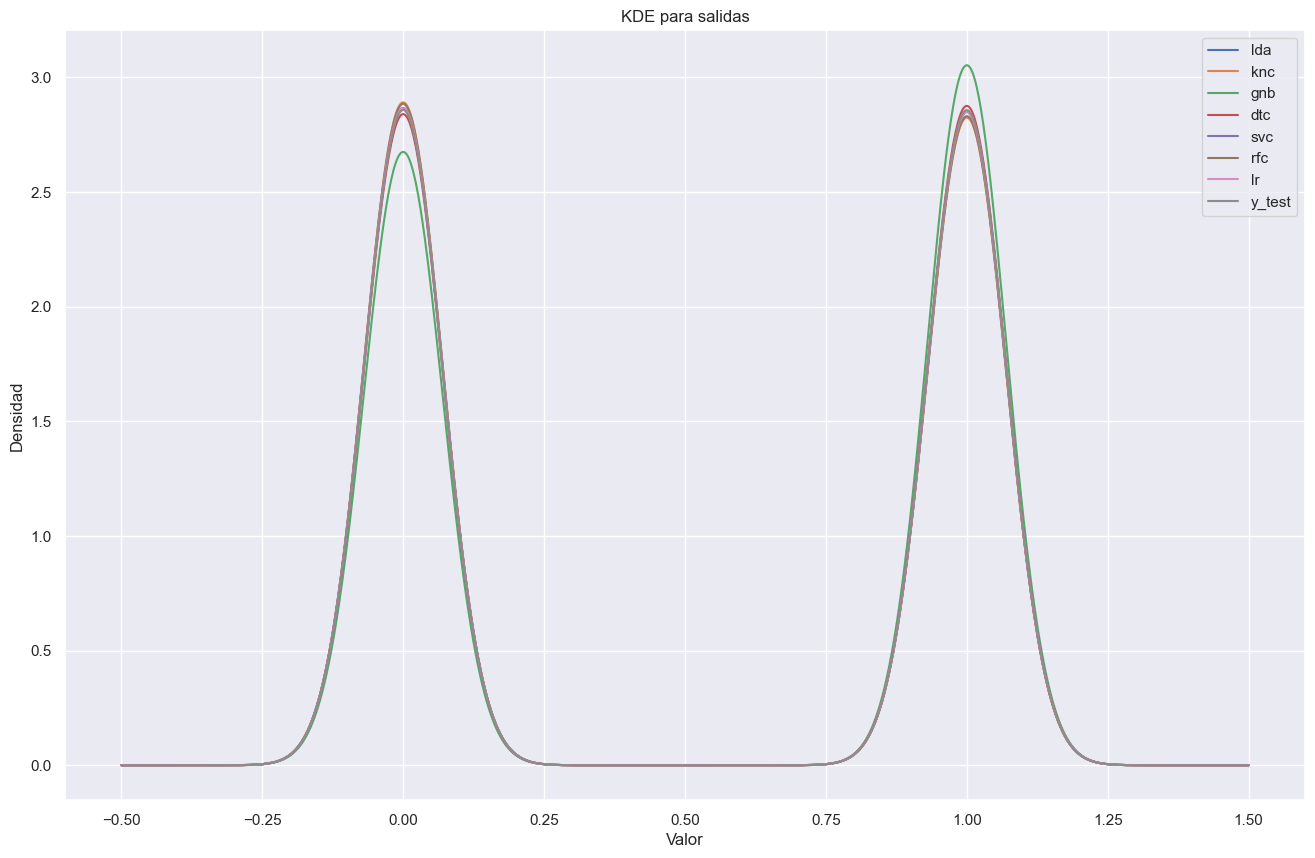

In [59]:
fig, ax = plt.subplots(figsize=(16, 10))
df_y.plot.kde(ax=ax)
plt.title('KDE para salidas')
plt.xlabel('Valor')
plt.ylabel('Densidad')

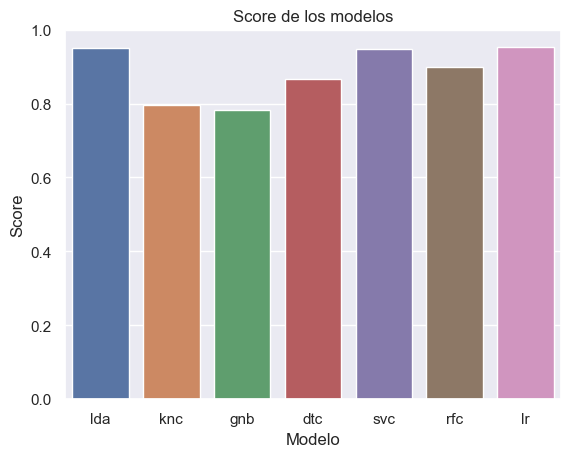

In [60]:
sns.barplot(data=df_metrics, x = 'Modelo', y = 'Score')
plt.title('Score de los modelos');

Vemos que todos los modelos tienen un buen score. Los 3 modelos con un mayor score son: lda (Linear Discriminant Analysis), svc (Support Vector Classifier) y lr (Logistic Regression). 

### Evaluación de los modelos

In [61]:
evaluation = pd.DataFrame({'model':['lda','knc','gnb','dtc','svc','rfc','lr']})

In [62]:
from sklearn.model_selection import cross_val_score

models = [lda, knc, gnb, dtc, svc, rfc, lr]
score_mean = []
score_std = []

for model in models:
    pipeline = Pipeline(
        [
            ('preprocessing', preprocessor),
            ('model', model)
        ]
    )
    X_array = X.values if isinstance(X, pd.DataFrame) else X

    score = cross_val_score(pipeline, X, y, cv=5, scoring='f1')
    print(score)
    score_mean.append(np.nanmean(score)) 
    score_std.append(np.nanstd(score))

[0.95067121 0.95372641        nan 0.95218827        nan]
[0.79989299 0.79620449        nan 0.80455731        nan]
[0.78598015 0.77428731        nan 0.79397798        nan]
[0.86550083 0.86272417        nan 0.87363279        nan]
[0.94698667 0.94699194        nan 0.9479738         nan]
[0.90505007 0.9005961         nan 0.90639817        nan]
[0.95142842 0.95309248        nan 0.95254309        nan]


In [63]:
evaluation['f1_cv'] = score_mean
evaluation['f1_std_cv'] = score_std
evaluation

,model,f1_cv,f1_std_cv
0,lda,0.952195,0.001247
1,knc,0.800218,0.003418
2,gnb,0.784748,0.008086
3,dtc,0.867286,0.004629
4,svc,0.947317,0.000464
5,rfc,0.904015,0.002479
6,lr,0.952355,0.000692


Seleccionamos el mejor modelo y buscamos sus mejores hiperparámetros:

In [66]:
pipeline_LR = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('pca', PCA(0.7)),
        ('model', LogisticRegression(random_state=42))
    ]
)

params_LR = {
    'model__penalty': ['l2', 'elasticnet'],
    'model__warm_start': [True, False],
    'model__random_state': [42]
}

gs_LR = GridSearchCV(pipeline_LR, params_LR, cv = 5, scoring = ['f1', 'accuracy'], refit = 'f1', n_jobs = -1)

gs_LR.fit(X, y)

best_model_LR = gs_LR.best_estimator_

print(f'Best parameter set: {gs_LR.best_params_}\n')
print(f'Scores: {classification_report(y, gs_LR.predict(X))}')

/Users/juliacorominasfont/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/juliacorominasfont/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/juliacorominasfont/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/juliacorominasfont/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarn

Best parameter set: {'model__penalty': 'l2', 'model__random_state': 42, 'model__warm_start': True}

Scores:               precision    recall  f1-score   support

           0       0.74      0.75      0.75     47418
           1       0.74      0.74      0.74     46926

    accuracy                           0.74     94344
   macro avg       0.74      0.74      0.74     94344
weighted avg       0.74      0.74      0.74     94344



Hacemos una matriz de confusión del mejor modelo:

Accuracy score: 0.74


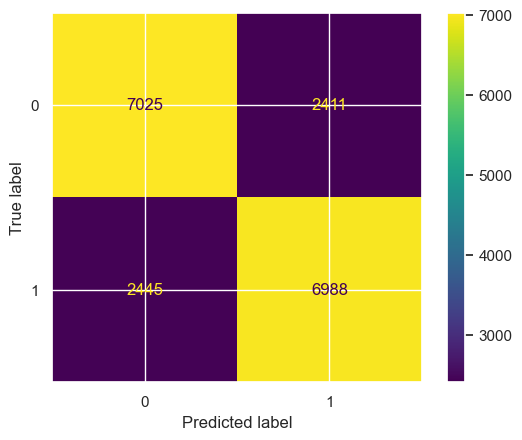

In [67]:
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

best_model_LR.fit(X_train, y_train)
print('Accuracy score: {0:.2f}'.format(best_model_LR.score(X_test, y_test)))

y_pred = best_model_LR.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

In [68]:
df_y['y_pred_best'] = y_pred

In [69]:
dump(df_y, 'df_y.df')

['df_y.df']

#### Predicciones

In [71]:
X_new = pd.DataFrame([['1991-339', 'Adelaide', 'Hard', 32, 'A', '1990-12-31', 1, 3, 'R32', 130.0, 1990, 101723, 'Magnus Larsson', 'R', 193.0, 'SWE', 20.7, 6.0, 2.0, 96.0, 55.0, 39.0, 25.0, 15.0, 2.0, 4.0, 56.0, 101414, 'Boris Becker', 'R', 190.0, 'GER', 23.1, 8.0, 3.0, 95.0, 62.0, 44.0, 23.0, 16.0, 6.0, 8.0, 2.0]],
                     columns= [['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'best_of', 'round', 'minutes', 'year',
       'Player1_id', 'Player1_name', 'Player1_hand', 'Player1_ht',
       'Player1_ioc', 'Player1_age', 'Player1_ace', 'Player1_df',
       'Player1_svpt', 'Player1_1stIn', 'Player1_1stWon', 'Player1_2ndWon',
       'Player1_SvGms', 'Player1_bpSaved', 'Player1_bpFaced', 'Player1_rank',
       'Player2_id', 'Player2_name', 'Player2_hand', 'Player2_ht',
       'Player2_ioc', 'Player2_age', 'Player2_ace', 'Player2_df',
       'Player2_svpt', 'Player2_1stIn', 'Player2_1stWon', 'Player2_2ndWon',
       'Player2_SvGms', 'Player2_bpSaved', 'Player2_bpFaced', 'Player2_rank']])

y_new = best_model_LR.predict(X_new)
y_new

array([1])

In [72]:
dump(best_model_LR, 'best_model.joblib')

['best_model.joblib']